# Help Navigate Robots

### This project is created as part of the Udacity Capstone Project - Data Scientist Nanodegree Program

### The dataset used for the purpose od this project is from competition: CareerCon 2019 on [Kaggle](https://www.kaggle.com/c/career-con-2019/overview). We all know that robots are already part of our daily lives and we know how important is for them to understand the environment we live in. For us is easy to go from one place to another and we know the information where we stand and on what we stand. But, for robots that is a huge process. We can contribute to that process with solving problems with real data and we can help navigate robots better.

### In this project, we will help robots to recognize the floor surface they are standing on using data collected from Inertial Measurement Units (IMU sensors).

### The IMU sensor data is collected while driving a small mobile robot over different floor surfaces on the university premises. The main task  is to predict which one of the nine floor types (carpet, tiles, concrete) the robot is on. This can be done by using sensor data such as acceleration and velocity. This way, we can improve the navigation of robots withous assistance across different surfaces.
**The data for this competition has been collected by Heikki Huttunen and Francesco Lomio from the Department of Signal Processing and Damoon Mohamadi, Kaan Celikbilek, Pedram Ghazi and Reza Ghabcheloo from the Department of Automation and Mechanical Engineering both from Tampere University, Finland.*

## Data Description

**X_[train/test].csv** - the input data, covering 10 sensor channels and 128 measurements per time series plus three ID columns:

-row_id: The ID for this row.<br/>

-series_id: ID number for the measurement series. Foreign key to y_train/sample_submission.<br/>

-measurement_number: Measurement number within the series.<br/>

The orientation channels encode the current angles how the robot is oriented as a quaternion (see [here](https://en.wikipedia.org/wiki/Conversion_between_quaternions_and_Euler_angles)). Angular velocity describes the angle and speed of motion, and linear acceleration components describe how the speed is changing at different times. The 10 sensor channels are:<br/>

orientation_X<br/>
<br/>
orientation_Y<br/>
<br/>
orientation_Z<br/>
<br/>
orientation_W<br/>
<br/>
angular_velocity_X<br/>
<br/>
angular_velocity_Y<br/>
<br/>
angular_velocity_Z<br/>
<br/>
linear_acceleration_X<br/>
<br/>
linear_acceleration_Y<br/>
<br/>
linear_acceleration_Z<br/>
<br/>
**y_train.csv** - the surfaces for training set.<br/>

-series_id: ID number for the measurement series.<br/>

-group_id: ID number for all of the measurements taken in a recording session. Provided for the training set only, to enable more cross validation strategies.<br/>

-surface: the target for this competition.<br/>

**sample_submission.csv** - a sample submission file in the correct format.<br/>
Submission File<br/>
For each series_id in the test set, you must predict a value for the surface variable. The file should have the following format:<br/>

series_id,surface<br/>
0,fine_concrete<br/>
1,concrete<br/>
2,concrete<br/>
etc.<br/>

### Overview
So, here we are going to work on training a model to recognize on what type of floor is the robot standing on in the current moment. That will be the main focus. I am going to use Stratified K-Folds cross-validator and RandomForestClassifier in this project. Choosing this algorithm was my own decision. The accuracy will tell us the performance of the model and how good it will predict the type of the floor and in that way, how good it will help the robot to know on what is standing. And also, we are going to see the confusion matrix in order to evaluate the accuracy of a classification. <br/>
About the results, it all depends on the data we have. If the data that we have when the robot is on different type of floor are similar to each other, then it will be harder to guess on what the robot stands.
<br/>
Let's dive into data exploration in order to find out!

# Data Exploration

Firstly, we are going to explore the data we have, so that we become familiar with the type of data we will be working on.

### Importing Libraries

In [108]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
from scipy.stats import kurtosis
from scipy.stats import skew
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
import pickle

In [109]:
X_train = pd.read_csv('data/X_train.csv')
X_test = pd.read_csv('data/X_test.csv')
target = pd.read_csv('data/y_train.csv')
sub = pd.read_csv('data/sample_submission.csv')

In [110]:
# Exploring the dataset
# We will see how the data looks like
# Training data
X_train.head(10)

,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
0,0_0,0,0,-0.75853,-0.63435,-0.10488,-0.10597,0.107650,0.017561,0.000767,-0.74857,2.103000,-9.7532
1,0_1,0,1,-0.75853,-0.63434,-0.10490,-0.10600,0.067851,0.029939,0.003385,0.33995,1.506400,-9.4128
2,0_2,0,2,-0.75853,-0.63435,-0.10492,-0.10597,0.007275,0.028934,-0.005978,-0.26429,1.592200,-8.7267
3,0_3,0,3,-0.75852,-0.63436,-0.10495,-0.10597,-0.013053,0.019448,-0.008974,0.42684,1.099300,-10.0960
4,0_4,0,4,-0.75852,-0.63435,-0.10495,-0.10596,0.005135,0.007652,0.005245,-0.50969,1.468900,-10.4410
5,0_5,0,5,-0.75853,-0.63439,-0.10483,-0.10580,0.059664,0.013043,-0.013231,-0.44745,0.992810,-10.4020
6,0_6,0,6,-0.75853,-0.63441,-0.10481,-0.10569,0.082140,0.044356,-0.002696,-0.14163,0.734970,-9.4296
7,0_7,0,7,-0.75852,-0.63444,-0.10480,-0.10561,0.056218,0.038162,-0.022931,-0.12160,0.075417,-8.6088
8,0_8,0,8,-0.75851,-0.63445,-0.10485,-0.10559,-0.012846,0.039004,-0.007831,1.60000,0.816110,-7.6426
9,0_9,0,9,-0.75851,-0.63443,-0.10489,-0.10567,-0.090082,0.027299,-0.009970,0.47496,0.909600,-8.8120


In [111]:
X_test.head(10) # Let's see the X_test - testing data

,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
0,0_0,0,0,0.91208,-0.38193,-0.050618,0.14028,-0.060205,0.071286,-0.18787,0.29492,2.8027,-9.6816
1,0_1,0,1,0.91220,-0.38165,-0.050573,0.14028,-0.033486,0.060210,-0.18206,0.14944,2.5408,-9.8521
2,0_2,0,2,0.91228,-0.38143,-0.050586,0.14032,-0.029686,0.029476,-0.18441,-0.49741,2.5853,-9.3835
3,0_3,0,3,0.91237,-0.38121,-0.050588,0.14035,-0.024217,0.037788,-0.18783,-0.32376,2.9966,-8.7415
4,0_4,0,4,0.91247,-0.38096,-0.050546,0.14042,-0.038047,0.083405,-0.20170,-0.70103,2.6498,-8.8432
5,0_5,0,5,0.91257,-0.38066,-0.050530,0.14055,-0.070700,0.096686,-0.20598,-0.10273,3.4873,-8.5442
6,0_6,0,6,0.91265,-0.38042,-0.050545,0.14067,-0.087024,0.053632,-0.19652,-0.61460,3.6240,-9.1235
7,0_7,0,7,0.91275,-0.38018,-0.050563,0.14073,-0.048412,0.035772,-0.20538,-0.45237,2.6256,-10.7820
8,0_8,0,8,0.91285,-0.37992,-0.050490,0.14075,0.007439,0.093085,-0.21097,-0.23560,3.4100,-10.1340
9,0_9,0,9,0.91298,-0.37960,-0.050453,0.14085,-0.018875,0.104330,-0.22342,-0.51823,4.0913,-8.5880


In [112]:
# This is how y train looks
target.head(10)

,series_id,group_id,surface
0,0,13,fine_concrete
1,1,31,concrete
2,2,20,concrete
3,3,31,concrete
4,4,22,soft_tiles
5,5,1,tiled
6,6,34,soft_pvc
7,7,31,concrete
8,8,33,hard_tiles_large_space
9,9,11,tiled


In [113]:
print('The shape of X_train is: ', X_train.shape)

The shape of X_train is:  (487680, 13)


In [114]:
print('The shape of X_test is: ', X_test.shape)

The shape of X_test is:  (488448, 13)


We have more data in X_test, than in X_train. That won't be a problem, actually, it is good to have balance training and testing data.

In [115]:
X_train.series_id.unique()

array([   0,    1,    2, ..., 3807, 3808, 3809], dtype=int64)

In [116]:
X_test.series_id.unique()

array([   0,    1,    2, ..., 3813, 3814, 3815], dtype=int64)

So, we have 6 more series in X_test, that are not in X_train.

In [117]:
len(X_train.measurement_number.value_counts())

128

So, for each series we have 128 measurements.<br/>
For example, series_id = 1 has 128 measurements, series_id = 2 same and so on.


#### Checking for missing values

In [118]:
X_train.isnull().sum()

row_id                   0
series_id                0
measurement_number       0
orientation_X            0
orientation_Y            0
orientation_Z            0
orientation_W            0
angular_velocity_X       0
angular_velocity_Y       0
angular_velocity_Z       0
linear_acceleration_X    0
linear_acceleration_Y    0
linear_acceleration_Z    0
dtype: int64

In [119]:
X_test.isnull().sum()

row_id                   0
series_id                0
measurement_number       0
orientation_X            0
orientation_Y            0
orientation_Z            0
orientation_W            0
angular_velocity_X       0
angular_velocity_Y       0
angular_velocity_Z       0
linear_acceleration_X    0
linear_acceleration_Y    0
linear_acceleration_Z    0
dtype: int64

In [120]:
target.isnull().sum()

series_id    0
group_id     0
surface      0
dtype: int64

We do not have missing values in the dataset.

In [121]:
# We will take just the series_id
df1 = X_test['series_id']
df2 = X_train['series_id']

In [122]:
# This are the series that are in X_test, and not in X_train
df_intersection = df1[~df1.isin(df2)].dropna(how = 'all')
df_intersection

487680    3810
487681    3810
487682    3810
487683    3810
487684    3810
          ... 
488443    3815
488444    3815
488445    3815
488446    3815
488447    3815
Name: series_id, Length: 768, dtype: int64

In [123]:
X_test[X_test['series_id'].isin(df_intersection.to_list())].describe() 
# This are basic stats for series_id that appear only in X_test

,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3812.500000,63.500000,0.337003,-0.131644,-0.017085,0.050452,-0.000984,0.011186,-0.030018,0.184216,2.915913,-9.364381
std,1.708938,36.973369,0.508982,0.767389,0.115323,0.078381,0.094922,0.050507,0.099772,1.281583,1.772065,2.214824
min,3810.000000,0.000000,-0.451190,-0.901650,-0.138930,-0.065797,-0.400180,-0.170710,-0.272710,-7.314100,-3.502700,-19.655000
25%,3811.000000,31.750000,-0.204643,-0.882522,-0.131210,-0.040565,-0.037407,-0.011643,-0.083618,-0.314090,1.666375,-9.796600
50%,3812.500000,63.500000,0.439235,-0.421170,-0.056427,0.067505,0.002001,0.006310,-0.005417,0.208475,2.939450,-9.376150
75%,3814.000000,95.250000,0.894423,0.867718,0.133083,0.135965,0.038191,0.047069,0.035923,0.633742,3.721350,-9.005425
max,3815.000000,127.000000,0.903020,0.968250,0.146690,0.137700,0.456310,0.177270,0.188970,9.547000,10.233000,3.052800


In [124]:
X_train.describe()

,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
count,487680.000000,487680.000000,487680.000000,487680.000000,487680.000000,487680.000000,487680.000000,487680.000000,487680.000000,487680.000000,487680.000000,487680.000000
mean,1904.500000,63.500000,-0.018050,0.075062,0.012458,-0.003804,0.000178,0.008338,-0.019184,0.129281,2.886468,-9.364886
std,1099.853353,36.949327,0.685696,0.708226,0.105972,0.104299,0.117764,0.088677,0.229153,1.870600,2.140067,2.845341
min,0.000000,0.000000,-0.989100,-0.989650,-0.162830,-0.156620,-2.371000,-0.927860,-1.268800,-36.067000,-121.490000,-75.386000
25%,952.000000,31.750000,-0.705120,-0.688980,-0.089466,-0.106060,-0.040752,-0.033191,-0.090743,-0.530833,1.957900,-10.193000
50%,1904.500000,63.500000,-0.105960,0.237855,0.031949,-0.018704,0.000084,0.005412,-0.005335,0.124980,2.879600,-9.365300
75%,2857.000000,95.250000,0.651803,0.809550,0.122870,0.097215,0.040527,0.048068,0.064604,0.792263,3.798800,-8.522700
max,3809.000000,127.000000,0.989100,0.988980,0.155710,0.154770,2.282200,1.079100,1.387300,36.797000,73.008000,65.839000


Anyway, from one point of view, it is good to have series not seen in the train set, because in that way we will see if the model can predict something different than what has been seen before.

In [125]:
# Let's see the target once again
target.head(10)

,series_id,group_id,surface
0,0,13,fine_concrete
1,1,31,concrete
2,2,20,concrete
3,3,31,concrete
4,4,22,soft_tiles
5,5,1,tiled
6,6,34,soft_pvc
7,7,31,concrete
8,8,33,hard_tiles_large_space
9,9,11,tiled


In [126]:
target.groupby('group_id').surface.nunique().max()

1

Each group_id is a unique recording session and has only one surface type.

In [127]:
X_train.groupby('series_id').measurement_number.nunique()

series_id
0       128
1       128
2       128
3       128
4       128
       ... 
3805    128
3806    128
3807    128
3808    128
3809    128
Name: measurement_number, Length: 3810, dtype: int64

There is a same number of series in X_train and y_train, numbered from 0 to 3809 (total 3810). Each series have 128 measurements.
Each series in train dataset is part of a group (numbered from 0 to 72).

In [128]:
# Let's just check the type of columns
X_train.dtypes

row_id                    object
series_id                  int64
measurement_number         int64
orientation_X            float64
orientation_Y            float64
orientation_Z            float64
orientation_W            float64
angular_velocity_X       float64
angular_velocity_Y       float64
angular_velocity_Z       float64
linear_acceleration_X    float64
linear_acceleration_Y    float64
linear_acceleration_Z    float64
dtype: object

In [129]:
X_test.dtypes

row_id                    object
series_id                  int64
measurement_number         int64
orientation_X            float64
orientation_Y            float64
orientation_Z            float64
orientation_W            float64
angular_velocity_X       float64
angular_velocity_Y       float64
angular_velocity_Z       float64
linear_acceleration_X    float64
linear_acceleration_Y    float64
linear_acceleration_Z    float64
dtype: object

In [130]:
target.dtypes

series_id     int64
group_id      int64
surface      object
dtype: object

Everything looks okay so far.

# Data Visualization

In [131]:
def plot_distribution(data,column,title, rot):
    '''This funcion plots the distribution of the data, with given column name, title of the plot, and rotation of text.'''
    
    f, ax = plt.subplots(1,1, figsize=(18,5))
    total = float(len(data))
    plott = sns.countplot(data[column], order = data[column].value_counts().index)
    plott.set_title(title)
    for i in ax.patches:
        height = i.get_height()
        ax.text(i.get_x()+i.get_width()/2., height + 3,'{:1.2f}%'.format(100*height/total),ha="center", rotation = rot) 
    plt.show()  


### 1. Distribution of target - surface

C:\Users\melanija\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


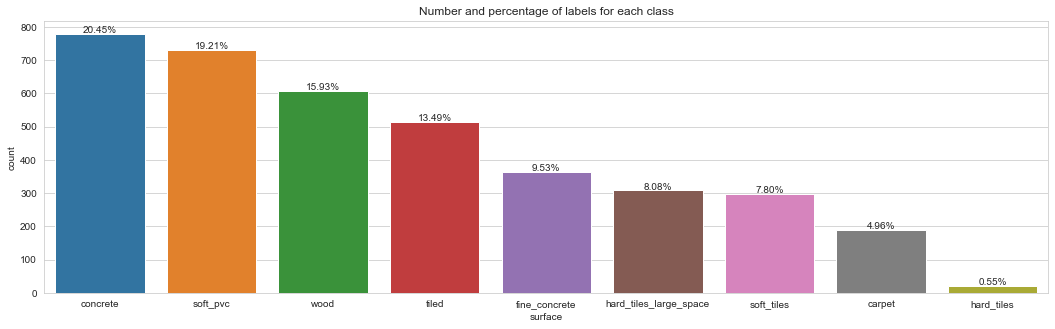

In [132]:
plot_distribution(data = target, column = 'surface', title = "Number and percentage of labels for each class", rot = None )

### 2. Distribution of group_id

C:\Users\melanija\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


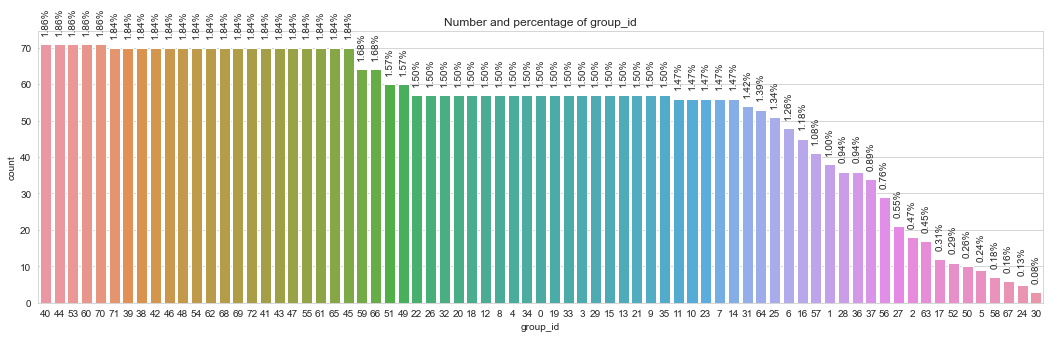

In [133]:
plot_distribution(data = target, column = 'group_id', title = "Number and percentage of group_id" , rot='90')

### 3. Correlation map for X_train

<AxesSubplot:>

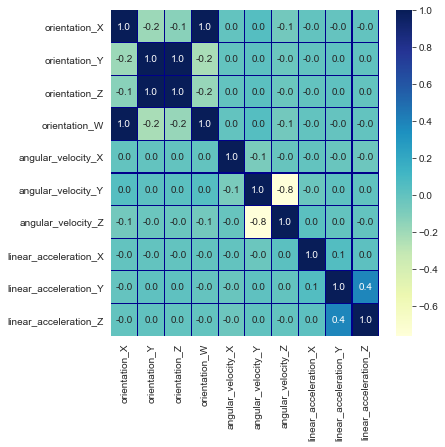

In [134]:
f,ax = plt.subplots(figsize=(6,6))
m = X_train.iloc[:,3:].corr()
sns.heatmap(m, annot=True, linecolor='darkblue', linewidths=.1, cmap="YlGnBu", fmt= '.1f',ax=ax)

Very strong correlation (1.0) is between orientation_X and orientation_W and between orientation_Z and orientation_Y.
There is a strong inverse correlation (-0.8) between angular_velocity_Z and angular_velocity_Y.
Also, there is a medium positive correlation (0.4) between linear_acceleration_Y and linear_acceleration_Z.

<AxesSubplot:>

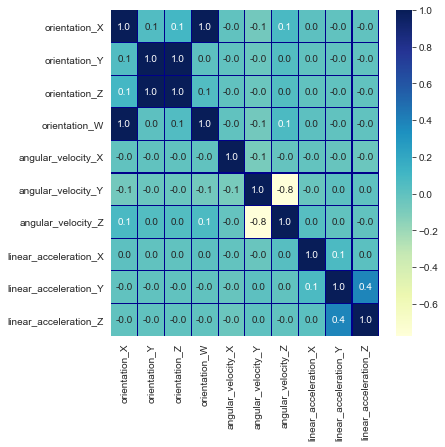

In [135]:
# For X_test
f,ax = plt.subplots(figsize=(6,6))
m = X_test.iloc[:,3:].corr()
sns.heatmap(m, annot=True, linecolor='darkblue', linewidths=.1, cmap="YlGnBu", fmt= '.1f',ax=ax)

### 4. Density plots of features


In [136]:
def plot_feature_distribution(df1, df2, label1, label2, features):
    '''Plot distribution of every feature in df1 and df2'''
    i = 0
    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(2,5,figsize=(16,8))

    for feature in features:
        i += 1
        plt.subplot(2,5,i)
        sns.distplot(df1[feature], hist=False, label=label1)
        sns.distplot(df2[feature], hist=False, label=label2)
        plt.xlabel(feature, fontsize=9)
        locs, labels = plt.xticks()
        plt.tick_params(axis='x', which='major', labelsize=8)
        plt.tick_params(axis='y', which='major', labelsize=8)
    plt.show();

C:\Users\melanija\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\melanija\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\melanija\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility)

<Figure size 432x288 with 0 Axes>

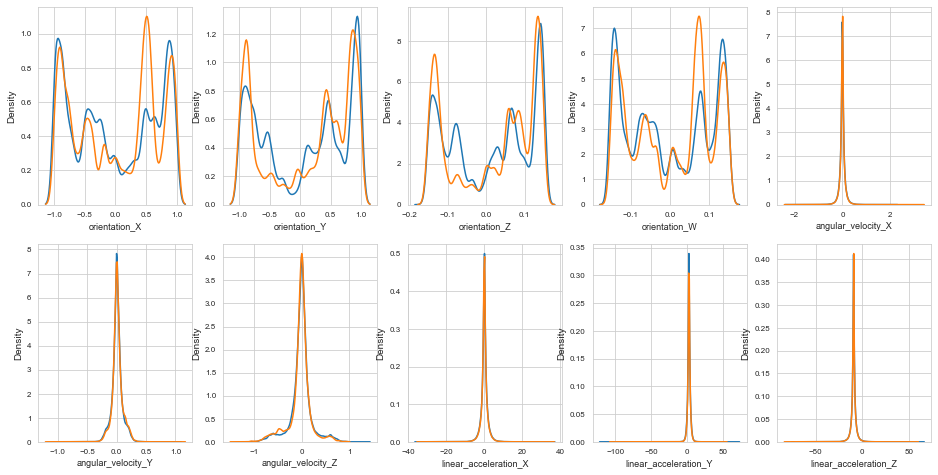

In [137]:
features = X_train.columns.values[3:13]
plot_feature_distribution(X_train, X_test, 'train', 'test', features)

In [138]:
def plot_feature_class_distribution(classes,tt, features):
    '''Plots the distribution of the features for every class'''
    i = 0
    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(5,2,figsize=(16,24))

    for feature in features:
        i += 1
        plt.subplot(5,2,i)
        for clas in classes:
            ttc = tt[tt['surface']==clas]
            sns.distplot(ttc[feature], hist=False,label=clas)
        plt.xlabel(feature, fontsize=9)
        locs, labels = plt.xticks()
        plt.tick_params(axis='x', which='major', labelsize=8)
        plt.tick_params(axis='y', which='major', labelsize=8)
        plt.legend()
    plt.show();

C:\Users\melanija\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\melanija\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\melanija\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility)

C:\Users\melanija\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\melanija\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\melanija\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility)

C:\Users\melanija\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\melanija\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\melanija\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility)

C:\Users\melanija\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\melanija\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\melanija\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility)

<Figure size 432x288 with 0 Axes>

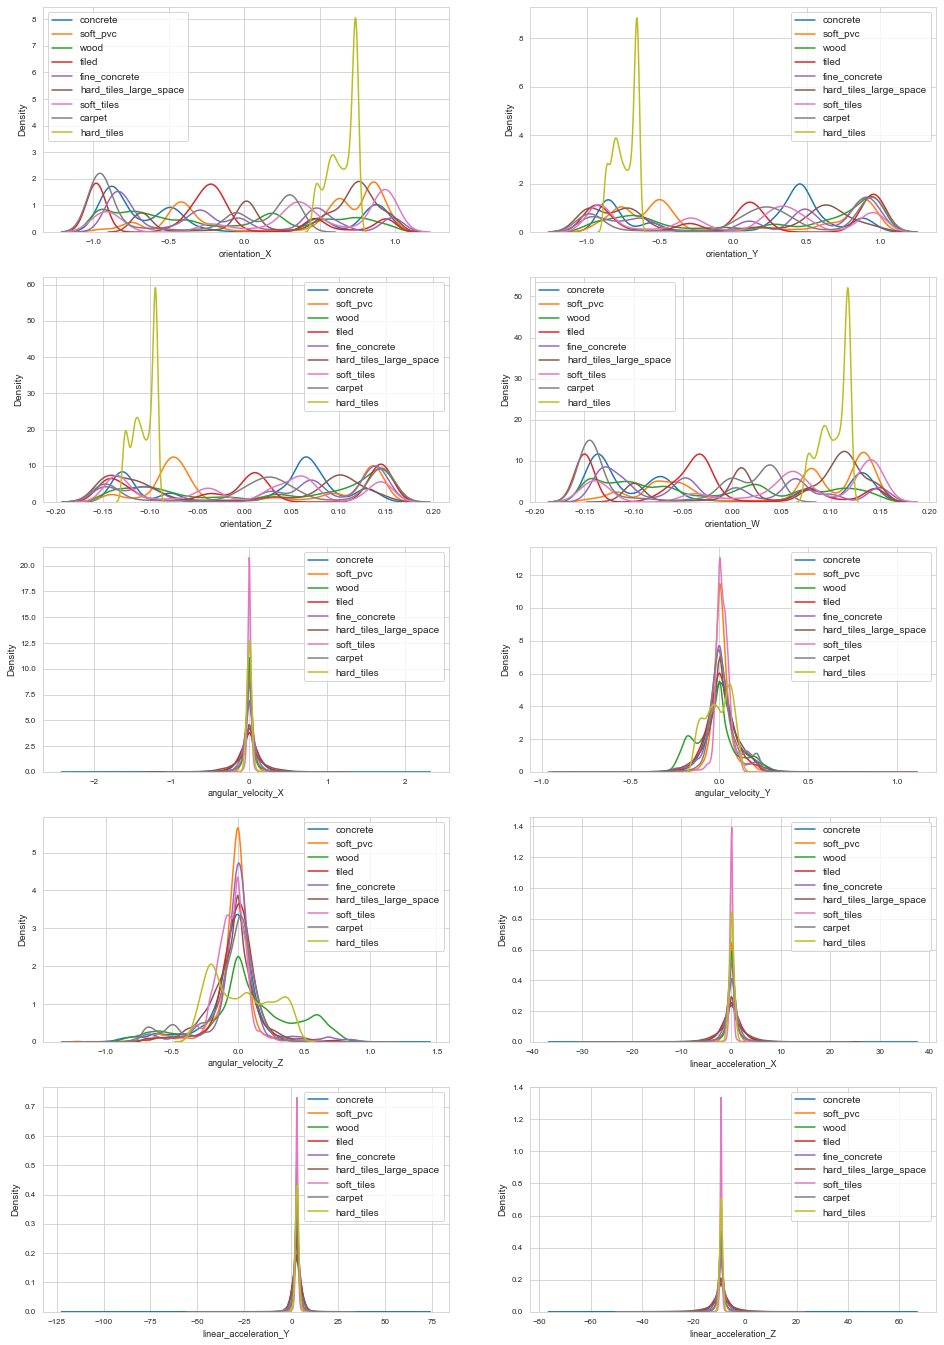

In [139]:
classes = (target['surface'].value_counts()).index
tt = X_train.merge(target, on='series_id', how='inner')
plot_feature_class_distribution(classes, tt, features)

Let's plot for one series to see the distribution there. For example, for series_id = 0.

In [140]:
series_0 = X_train[X_train['series_id'] == 0]

In [141]:
series_0

,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
0,0_0,0,0,-0.75853,-0.63435,-0.10488,-0.10597,0.107650,0.017561,0.000767,-0.74857,2.10300,-9.7532
1,0_1,0,1,-0.75853,-0.63434,-0.10490,-0.10600,0.067851,0.029939,0.003385,0.33995,1.50640,-9.4128
2,0_2,0,2,-0.75853,-0.63435,-0.10492,-0.10597,0.007275,0.028934,-0.005978,-0.26429,1.59220,-8.7267
3,0_3,0,3,-0.75852,-0.63436,-0.10495,-0.10597,-0.013053,0.019448,-0.008974,0.42684,1.09930,-10.0960
4,0_4,0,4,-0.75852,-0.63435,-0.10495,-0.10596,0.005135,0.007652,0.005245,-0.50969,1.46890,-10.4410
...,...,...,...,...,...,...,...,...,...,...,...,...,...
123,0_123,0,123,-0.75943,-0.63316,-0.10470,-0.10677,0.041741,0.012857,0.016053,-0.80827,1.79890,-6.8687
124,0_124,0,124,-0.75945,-0.63313,-0.10473,-0.10683,-0.052041,-0.014752,0.021632,-0.36055,2.35620,-6.8926
125,0_125,0,125,-0.75949,-0.63309,-0.10467,-0.10690,-0.083083,-0.044480,0.031726,-0.98193,0.97328,-9.9795
126,0_126,0,126,-0.75950,-0.63307,-0.10464,-0.10693,-0.001305,-0.031012,0.017241,-0.72591,0.34931,-11.9770


In [142]:
series_0.describe()

,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
count,128.0,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000
mean,0.0,63.500000,-0.758666,-0.634008,-0.105474,-0.106470,-0.002481,-0.003306,0.007532,0.263418,2.984195,-9.320391
std,0.0,37.094474,0.000363,0.000471,0.000432,0.000389,0.052800,0.031544,0.017127,0.911175,1.387790,1.095040
min,0.0,0.000000,-0.759530,-0.634560,-0.106140,-0.107050,-0.160410,-0.079404,-0.030181,-1.864400,0.075417,-12.512000
25%,0.0,31.750000,-0.758927,-0.634383,-0.105873,-0.106775,-0.029069,-0.027110,-0.005289,-0.362872,1.791050,-9.875850
50%,0.0,63.500000,-0.758530,-0.634270,-0.105500,-0.106555,-0.005082,-0.004037,0.006842,0.231665,3.407550,-9.429950
75%,0.0,95.250000,-0.758367,-0.633530,-0.105077,-0.106130,0.035803,0.020031,0.020088,0.905635,4.119200,-8.633425
max,0.0,127.000000,-0.758220,-0.633060,-0.104610,-0.105590,0.107650,0.072698,0.051720,2.853800,5.386400,-6.268100


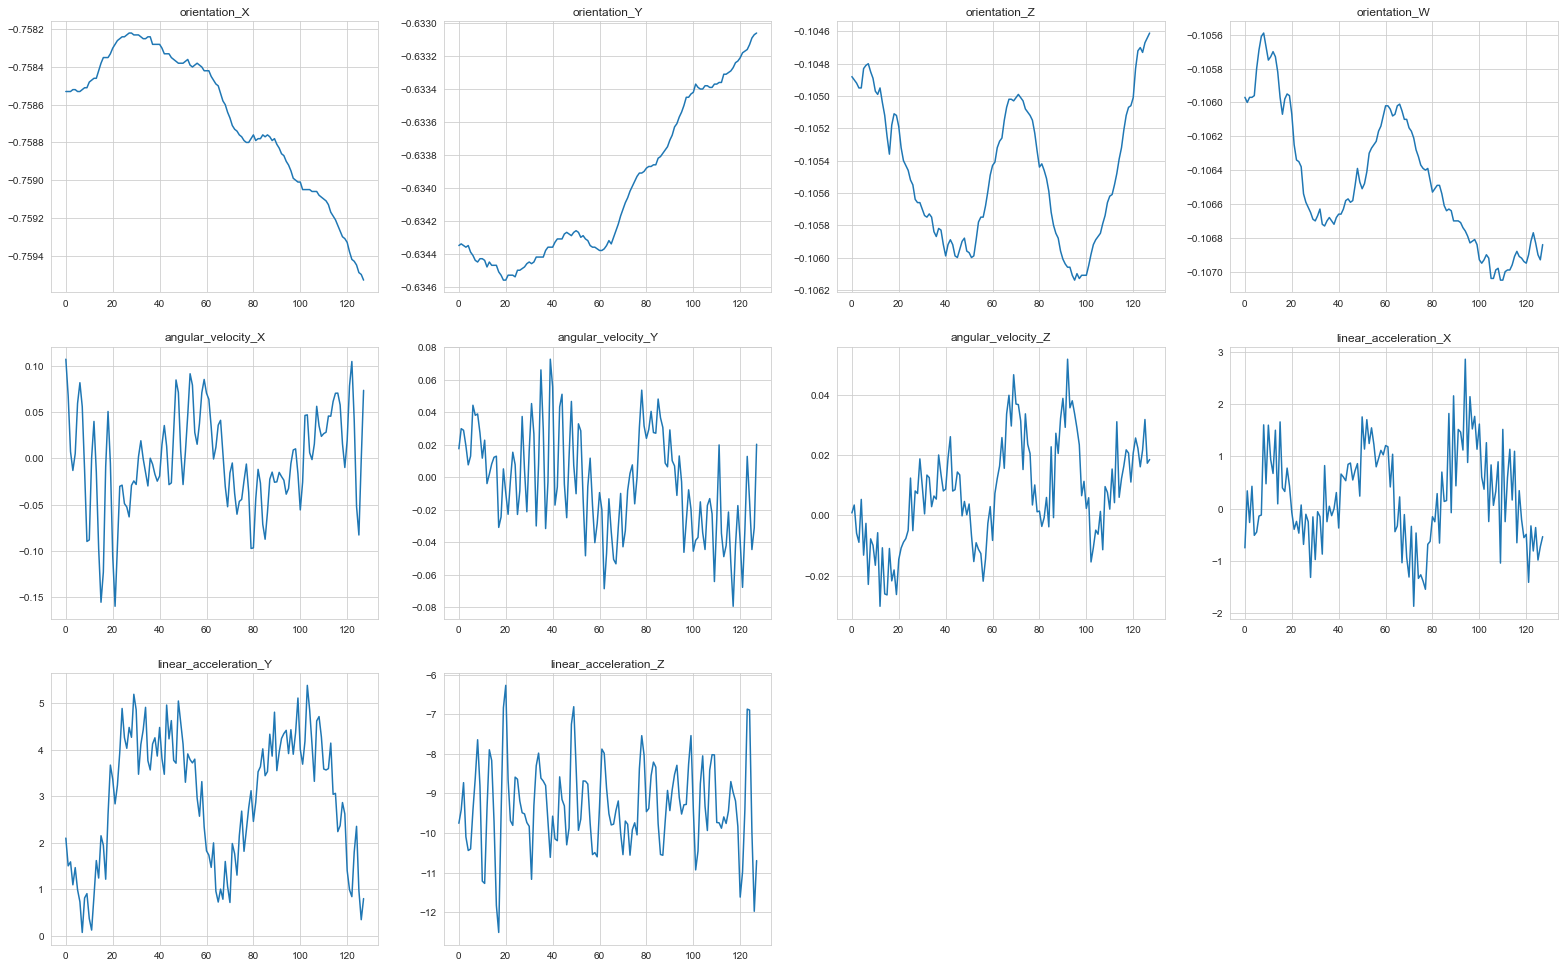

In [143]:
plt.figure(figsize=(27, 17))
for i, col in enumerate(series_0.columns[3:]):
    plt.subplot(3, 4, i + 1)
    plt.plot(series_0[col])
    plt.title(col)

From this plots we can see that maybe there is some pattern in linear_acceleration_Y. Also, orientation_X and orientation_Y are going in different ways.

# Data preprocessing

### 1. Feature Engineering

C:\Users\melanija\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\melanija\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\melanija\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility)

<Figure size 432x288 with 0 Axes>

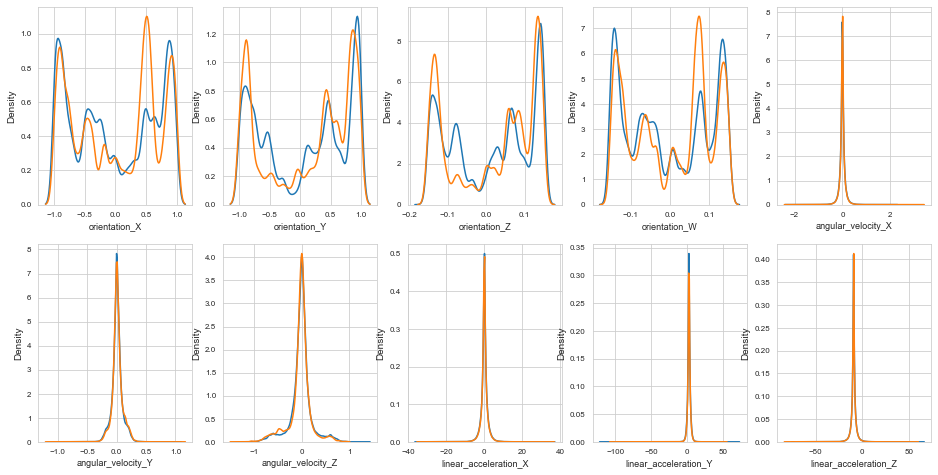

In [144]:
# Now let's see the distribution of the features in X_train and X_test once again
features = X_train.columns.values[3:]
plot_feature_distribution(X_train, X_test, 'train', 'test', features) 

From the distribution of the features in X_train and X_test, we can see that it is almost similiar, which is good. Only, there is a small difference in the orientations.
It is important to mention that we should use scaling here, since the features are all in different units.

But now, let's see the distribution of the different floor types.


C:\Users\melanija\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\melanija\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\melanija\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility)

C:\Users\melanija\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\melanija\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\melanija\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility)

C:\Users\melanija\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\melanija\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\melanija\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility)

C:\Users\melanija\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\melanija\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\melanija\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility)

<Figure size 432x288 with 0 Axes>

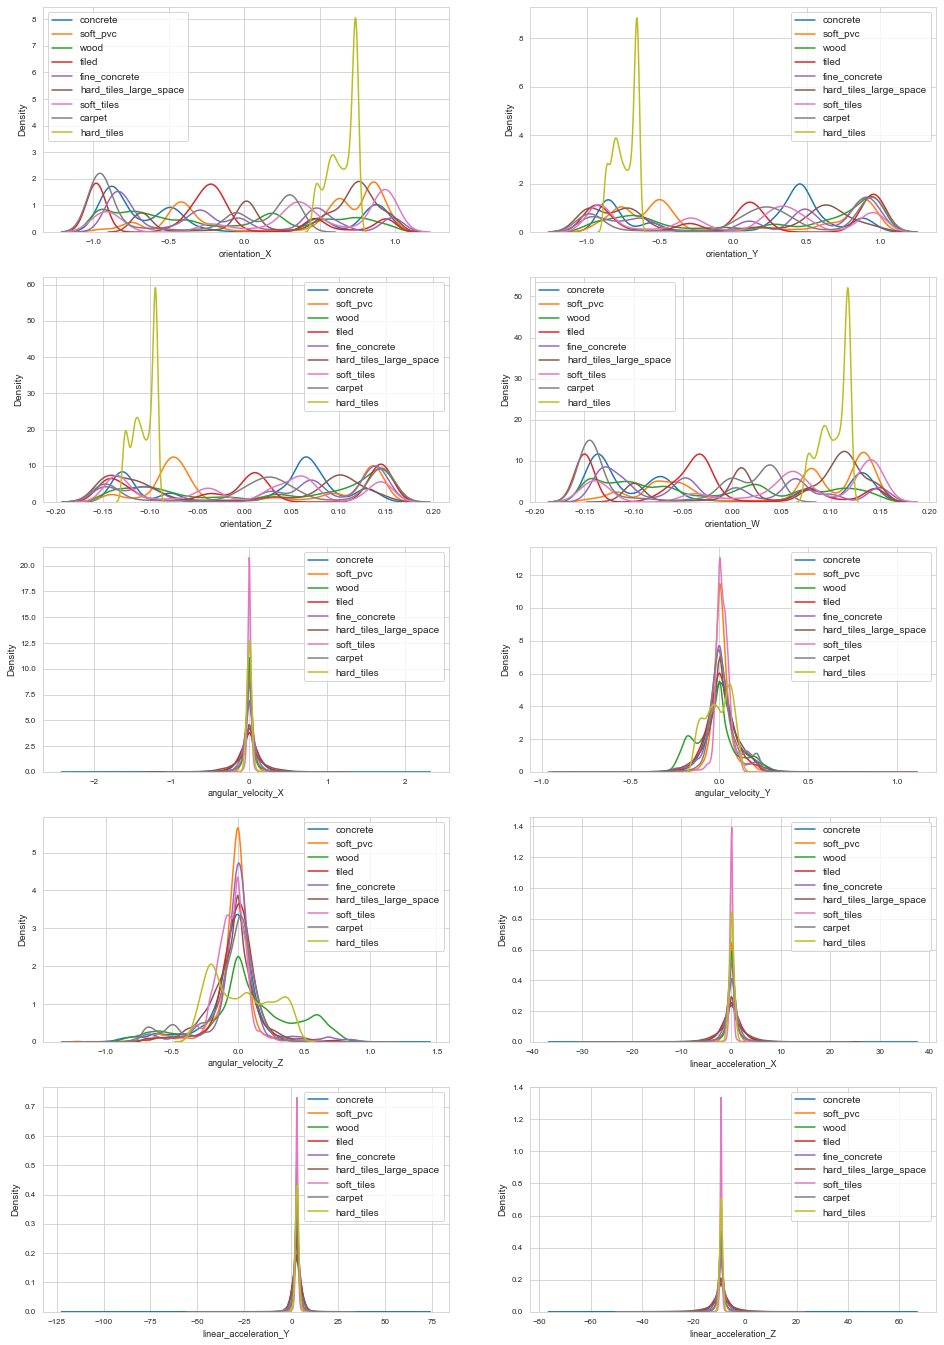

In [145]:
classes = (target['surface'].value_counts()).index
data_merged = X_train.merge(target, on='series_id', how='inner')
plot_feature_class_distribution(classes, data_merged, features)

We can see that there are differences between surfaces, which is good. In that way, it will be easy to classify them. Knowing that there are differences and that in most of the cases, the variables follow normal distribution, we can get more features like the standard deviation, mean, meadian, variance and so on.


So, we have four coordinates: X, Y, Z and W.<br/>
For this problem, we need Euler angles. It is good to mention that Euler angles are limited by a phenomenon called "gimbal lock", which prevents them from measuring orientation when the pitch angle approaches +/- 90 degrees.
From other side, quaternions provide an alternative measurement technique that is not limited by gimbal lock. But, quaternions are less intuitive than Euler Angles and are more complicated.

In [39]:
def quaternion_to_euler(x, y, z, w):
    '''This function converts quaternion coordinates to Euler angles'''
    t0 = +2.0 * (w * x + y * z)
    t1 = +1.0 - 2.0 * (x * x + y * y)
    X = math.atan2(t0, t1)

    t2 = +2.0 * (w * y - z * x)
    t2 = +1.0 if t2 > +1.0 else t2
    t2 = -1.0 if t2 < -1.0 else t2
    Y = math.asin(t2)

    t3 = +2.0 * (w * z + x * y)
    t4 = +1.0 - 2.0 * (y * y + z * z)
    Z = math.atan2(t3, t4)

    return X, Y, Z

Before we jump into converting quaternion into Euler angles, we have to normilize quaternion. And we have good explanation on that on this link: https://stackoverflow.com/questions/11667783/quaternion-and-normalization

In [40]:
def normalization_quaternion(data):
    '''Normalization of quaternion'''
    data['norm_quat'] = (data['orientation_X']**2 + data['orientation_Y']**2 + data['orientation_Z']**2 + data['orientation_W']**2)
    data['mod_quat'] = (data['norm_quat'])**0.5
    data['norm_X'] = data['orientation_X'] / data['mod_quat']
    data['norm_Y'] = data['orientation_Y'] / data['mod_quat']
    data['norm_Z'] = data['orientation_Z'] / data['mod_quat']
    data['norm_W'] = data['orientation_W'] / data['mod_quat']
    
    return data

X_train = normalization_quaternion(X_train)
X_test = normalization_quaternion(X_test)

X_train.head()

,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z,norm_quat,mod_quat,norm_X,norm_Y,norm_Z,norm_W
0,0_0,0,0,-0.75853,-0.63435,-0.10488,-0.10597,0.107650,0.017561,0.000767,-0.74857,2.1030,-9.7532,0.999997,0.999999,-0.758531,-0.634351,-0.10488,-0.10597
1,0_1,0,1,-0.75853,-0.63434,-0.10490,-0.10600,0.067851,0.029939,0.003385,0.33995,1.5064,-9.4128,0.999995,0.999998,-0.758532,-0.634342,-0.10490,-0.10600
2,0_2,0,2,-0.75853,-0.63435,-0.10492,-0.10597,0.007275,0.028934,-0.005978,-0.26429,1.5922,-8.7267,1.000006,1.000003,-0.758528,-0.634348,-0.10492,-0.10597
3,0_3,0,3,-0.75852,-0.63436,-0.10495,-0.10597,-0.013053,0.019448,-0.008974,0.42684,1.0993,-10.0960,1.000009,1.000005,-0.758516,-0.634357,-0.10495,-0.10597
4,0_4,0,4,-0.75852,-0.63435,-0.10495,-0.10596,0.005135,0.007652,0.005245,-0.50969,1.4689,-10.4410,0.999995,0.999997,-0.758522,-0.634352,-0.10495,-0.10596


In [41]:
# Converting quaternions to Euler angles
def quat_to_euler_full (data):
    """Quaternions to Euler Angles full function with data preparation"""
    x = data['norm_X'].tolist()
    y = data['norm_Y'].tolist()
    z = data['norm_Z'].tolist()
    w = data['norm_W'].tolist()

    euler_x, euler_y, euler_z = [], [], []
    for i in range(len(x)):
        xx, yy, zz = quaternion_to_euler(x[i], y[i], z[i], w[i])
        euler_x.append(xx)
        euler_y.append(yy)
        euler_z.append(zz)
    
    data['euler_x'] = euler_x
    data['euler_y'] = euler_y
    data['euler_z'] = euler_z
    return data

X_train = quat_to_euler_full(X_train)
X_test = quat_to_euler_full(X_test)

X_train.head()


,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,...,linear_acceleration_Z,norm_quat,mod_quat,norm_X,norm_Y,norm_Z,norm_W,euler_x,euler_y,euler_z
0,0_0,0,0,-0.75853,-0.63435,-0.10488,-0.10597,0.107650,0.017561,0.000767,...,-9.7532,0.999997,0.999999,-0.758531,-0.634351,-0.10488,-0.10597,2.843273,-0.024668,1.396667
1,0_1,0,1,-0.75853,-0.63434,-0.10490,-0.10600,0.067851,0.029939,0.003385,...,-9.4128,0.999995,0.999998,-0.758532,-0.634342,-0.10490,-0.10600,2.843201,-0.024662,1.396651
2,0_2,0,2,-0.75853,-0.63435,-0.10492,-0.10597,0.007275,0.028934,-0.005978,...,-8.7267,1.000006,1.000003,-0.758528,-0.634348,-0.10492,-0.10597,2.843222,-0.024728,1.396677
3,0_3,0,3,-0.75852,-0.63436,-0.10495,-0.10597,-0.013053,0.019448,-0.008974,...,-10.0960,1.000009,1.000005,-0.758516,-0.634357,-0.10495,-0.10597,2.843183,-0.024769,1.396712
4,0_4,0,4,-0.75852,-0.63435,-0.10495,-0.10596,0.005135,0.007652,0.005245,...,-10.4410,0.999995,0.999997,-0.758522,-0.634352,-0.10495,-0.10596,2.843197,-0.024785,1.396698


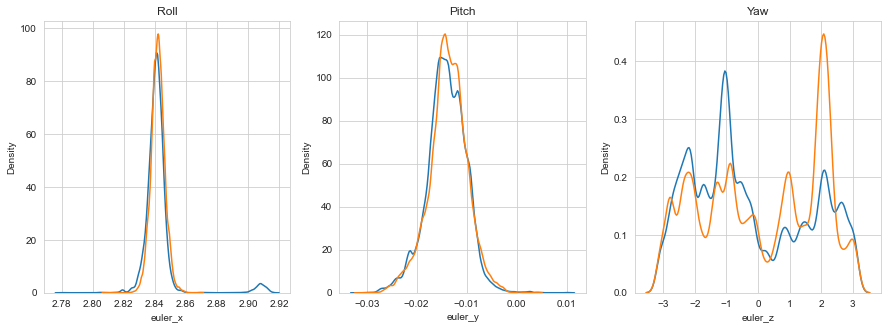

In [42]:
# Now let's plot the Euler angles
def plot_euler(data_train, data_test):
    fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(15, 5))

    ax1.set_title('Roll')
    sns.kdeplot(data_train['euler_x'], ax=ax1, label="train")
    sns.kdeplot(data_test['euler_x'], ax=ax1, label="test")

    ax2.set_title('Pitch')
    sns.kdeplot(data_train['euler_y'], ax=ax2, label="train")
    sns.kdeplot(data_test['euler_y'], ax=ax2, label="test")

    ax3.set_title('Yaw')
    sns.kdeplot(data_train['euler_z'], ax=ax3, label="train")
    sns.kdeplot(data_test['euler_z'], ax=ax3, label="test")

    plt.show()
    
plot_euler(X_train, X_test)

We can see from the plot that there is something wrong with Yaw - that is euler_z.

The orientation Z is very important because if we have moving robot that have changed the surface from one type to another, for example from flat and smooth to a surface that is not flat and smooth, then the robot can lose balance and can bounce. Having orientation Z under control is important for that purpose.

For a further analysis, I suggest to look on how to control orientation Z more. In that way, we can improve our analysis and results.

#### Let's add more features!

In [43]:
def feature_engineering(data):
    '''Creating more features'''
    df = pd.DataFrame()
    data['total_angular_velocity'] = (data['angular_velocity_X']**2 + data['angular_velocity_Y']**2 + data['angular_velocity_Z']**2)** 0.5
    data['total_linear_acceleration'] = (data['linear_acceleration_X']**2 + data['linear_acceleration_Y']**2 + data['linear_acceleration_Z']**2)**0.5
    data['total_xyz'] = (data['orientation_X']**2 + data['orientation_Y']**2 + data['orientation_Z']**2)**0.5
    data['acc_vs_vel'] = data['total_linear_acceleration'] / data['total_angular_velocity']
    
    def mean_change_of_abs_change(x):
        return np.mean(np.diff(np.abs(np.diff(x))))
    
    for col in data.columns:
        if col in ['row_id','series_id','measurement_number']:
            continue
        df[col + '_min'] = data.groupby(['series_id'])[col].min()
        df[col + '_max'] = data.groupby(['series_id'])[col].max()
        df[col + '_range'] = df[col + '_max'] - df[col + '_min']
        df[col + '_maxtoMin'] = df[col + '_max'] / df[col + '_min']
        df[col + '_abs_max'] = data.groupby(['series_id'])[col].apply(lambda x: np.max(np.abs(x)))
        df[col + '_abs_min'] = data.groupby(['series_id'])[col].apply(lambda x: np.min(np.abs(x)))
        df[col + '_abs_avg'] = (df[col + '_abs_min'] + df[col + '_abs_max'])/2
        df[col + '_mean'] = data.groupby(['series_id'])[col].mean()
        df[col + '_median'] = data.groupby(['series_id'])[col].median()
        df[col + '_std'] = data.groupby(['series_id'])[col].std()
        df[col + '_mean_abs_chg'] = data.groupby(['series_id'])[col].apply(lambda x: np.mean(np.abs(np.diff(x))))
        df[col + '_mean_change_of_abs_change'] = data.groupby('series_id')[col].apply(mean_change_of_abs_change)
        
    return df


X_train = feature_engineering(X_train)
X_test = feature_engineering(X_test)
X_train.head() # Let's see how it looks now

,orientation_X_min,orientation_X_max,orientation_X_range,orientation_X_maxtoMin,orientation_X_abs_max,orientation_X_abs_min,orientation_X_abs_avg,orientation_X_mean,orientation_X_median,orientation_X_std,...,acc_vs_vel_range,acc_vs_vel_maxtoMin,acc_vs_vel_abs_max,acc_vs_vel_abs_min,acc_vs_vel_abs_avg,acc_vs_vel_mean,acc_vs_vel_median,acc_vs_vel_std,acc_vs_vel_mean_abs_chg,acc_vs_vel_mean_change_of_abs_change
series_id,,,,,,,,,,,,,,,,,,,,,
0,-0.75953,-0.75822,0.00131,0.998275,0.75953,0.75822,0.758875,-0.758666,-0.758530,0.000363,...,939.428062,17.735749,995.561076,56.133014,525.847045,223.282937,187.471573,135.641510,114.896199,1.309785
1,-0.95896,-0.95837,0.00059,0.999385,0.95896,0.95837,0.958665,-0.958606,-0.958595,0.000151,...,578.888393,18.574922,611.826712,32.938319,322.382516,118.973908,98.477877,88.488750,57.943094,0.508448
2,-0.51434,-0.50944,0.00490,0.990473,0.51434,0.50944,0.511890,-0.512057,-0.512035,0.001377,...,851.434788,17.115041,904.269577,52.834789,478.552183,190.134237,146.667138,132.789650,83.878164,-0.078679
3,-0.93968,-0.93884,0.00084,0.999106,0.93968,0.93884,0.939260,-0.939169,-0.939170,0.000227,...,794.619341,71.288762,805.924410,11.305069,408.614740,115.134804,84.403391,112.264757,76.773215,0.928182
4,-0.89689,-0.88673,0.01016,0.988672,0.89689,0.88673,0.891810,-0.891301,-0.890940,0.002955,...,71.693101,2.797034,111.588333,39.895232,75.741783,66.057675,61.430180,16.611029,5.618844,-0.003968


We can add some extra features, that maybe will be good for our model.
Those extra features are kurtosis, skewness, quantile (0.25, 0.75, 0.95, iqr).

In [44]:
def _kurtosis(x):
    return kurtosis(x)

def skewness(x):
    return skew(x)

def extra_features(data):
    
    df = pd.DataFrame()
    
    for col in data.columns:
        if col in ['row_id','series_id','measurement_number']:
            continue
        if 'orientation' in col:
            continue

        df[col + '_skewness'] = data.groupby(['series_id'])[col].apply(skewness)
        df[col + '_q25'] = data.groupby(['series_id'])[col].quantile(0.25)
        df[col + '_q75'] = data.groupby(['series_id'])[col].quantile(0.75)
        df[col + '_q95'] = data.groupby(['series_id'])[col].quantile(0.95)
        df[col + '_iqr'] = df[col + '_q75'] - df[col + '_q25']
        df[col + '_kurtosis'] = data.groupby(['series_id'])[col].apply(_kurtosis)
        
    return df

In [45]:
# Adding extra features
X_train = extra_features(X_train)
X_test = extra_features(X_test)
X_train.head()

,angular_velocity_X_min_skewness,angular_velocity_X_min_q25,angular_velocity_X_min_q75,angular_velocity_X_min_q95,angular_velocity_X_min_iqr,angular_velocity_X_min_kurtosis,angular_velocity_X_max_skewness,angular_velocity_X_max_q25,angular_velocity_X_max_q75,angular_velocity_X_max_q95,...,acc_vs_vel_mean_abs_chg_q75,acc_vs_vel_mean_abs_chg_q95,acc_vs_vel_mean_abs_chg_iqr,acc_vs_vel_mean_abs_chg_kurtosis,acc_vs_vel_mean_change_of_abs_change_skewness,acc_vs_vel_mean_change_of_abs_change_q25,acc_vs_vel_mean_change_of_abs_change_q75,acc_vs_vel_mean_change_of_abs_change_q95,acc_vs_vel_mean_change_of_abs_change_iqr,acc_vs_vel_mean_change_of_abs_change_kurtosis
series_id,,,,,,,,,,,,,,,,,,,,,
0,0.0,-0.16041,-0.16041,-0.16041,0.0,-3.0,0.0,0.107650,0.107650,0.107650,...,114.896199,114.896199,0.0,-3.0,0.0,1.309785,1.309785,1.309785,0.0,-3.0
1,0.0,-0.25480,-0.25480,-0.25480,0.0,-3.0,0.0,0.283420,0.283420,0.283420,...,57.943094,57.943094,0.0,-3.0,0.0,0.508448,0.508448,0.508448,0.0,-3.0
2,0.0,-0.15271,-0.15271,-0.15271,0.0,-3.0,0.0,0.141920,0.141920,0.141920,...,83.878164,83.878164,0.0,-3.0,0.0,-0.078679,-0.078679,-0.078679,0.0,-3.0
3,0.0,-0.40152,-0.40152,-0.40152,0.0,-3.0,0.0,0.519130,0.519130,0.519130,...,76.773215,76.773215,0.0,-3.0,0.0,0.928182,0.928182,0.928182,0.0,-3.0
4,0.0,-0.10407,-0.10407,-0.10407,0.0,-3.0,0.0,0.080904,0.080904,0.080904,...,5.618844,5.618844,0.0,-3.0,0.0,-0.003968,-0.003968,-0.003968,0.0,-3.0


According to some discussions on kaggle for the dataset, each series is a part of longer periods of aquisition and those periods have been cut into chunks with 128 samples each. That means that the series are not independent and that there is a leakage between them. The leakage is through orientation data.


Since we created new features, it is good to check for NAN data, to be sure, before we build the model.

In [46]:
X_train.fillna(0,inplace=True)
X_test.fillna(0,inplace=True)
X_train.replace(-np.inf,0,inplace=True)
X_test.replace(-np.inf,0,inplace=True)
X_train.replace(np.inf,0,inplace=True)
X_test.replace(np.inf,0,inplace=True)

In [78]:
# We will use LabelEncoder to give labels to the surfaces we have as target
le = LabelEncoder()
target['surface'] = le.fit_transform(target['surface'])

In [82]:
target

,series_id,group_id,surface
0,0,13,2
1,1,31,1
2,2,20,1
3,3,31,1
4,4,22,6
...,...,...,...
3805,3805,55,7
3806,3806,67,8
3807,3807,48,2
3808,3808,54,7


In [49]:
target['surface_label'].value_counts()

1    779
5    732
8    607
7    514
2    363
4    308
6    297
0    189
3     21
Name: surface_label, dtype: int64

Now, we are going to scale the data, because there are in different ranges.

In [95]:
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train))
X_test_scaled = pd.DataFrame(scaler.transform(X_test))

# Building model

In [98]:
folds = StratifiedKFold(n_splits=20, shuffle=True, random_state=59)
# StratifiedKFold: This cross-validation object is a variation of KFold that returns stratified folds. 
# The folds are made by preserving the percentage of samples for each class. KFold: Split dataset into k consecutive folds.

sub_preds_rf = np.zeros((X_test_scaled.shape[0], 9))
oof_preds_rf = np.zeros((X_train_scaled.shape[0]))
score = 0
for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train_scaled, target['surface'])):
    clf =  RandomForestClassifier(n_estimators = 500, n_jobs = -1)
    clf.fit(X_train_scaled.iloc[trn_idx], target['surface'][trn_idx])
    oof_preds_rf[val_idx] = clf.predict(X_train_scaled.iloc[val_idx])
    sub_preds_rf += clf.predict_proba(X_test_scaled) / folds.n_splits
    score += clf.score(X_train_scaled.iloc[val_idx], target['surface'][val_idx])
    print('Fold: {} score: {}'.format(fold_,clf.score(X_train_scaled.iloc[val_idx], target['surface'][val_idx])))
print('Avg Accuracy', score / folds.n_splits)

Fold: 0 score: 0.8900523560209425
Fold: 1 score: 0.9162303664921466
Fold: 2 score: 0.9528795811518325
Fold: 3 score: 0.93717277486911
Fold: 4 score: 0.9214659685863874
Fold: 5 score: 0.9476439790575916
Fold: 6 score: 0.9214659685863874
Fold: 7 score: 0.8952879581151832
Fold: 8 score: 0.8952879581151832
Fold: 9 score: 0.9109947643979057
Fold: 10 score: 0.8894736842105263
Fold: 11 score: 0.9421052631578948
Fold: 12 score: 0.868421052631579
Fold: 13 score: 0.9
Fold: 14 score: 0.8947368421052632
Fold: 15 score: 0.9210526315789473
Fold: 16 score: 0.9210526315789473
Fold: 17 score: 0.9421052631578948
Fold: 18 score: 0.9368421052631579
Fold: 19 score: 0.9315789473684211
Avg Accuracy 0.9167925048222652


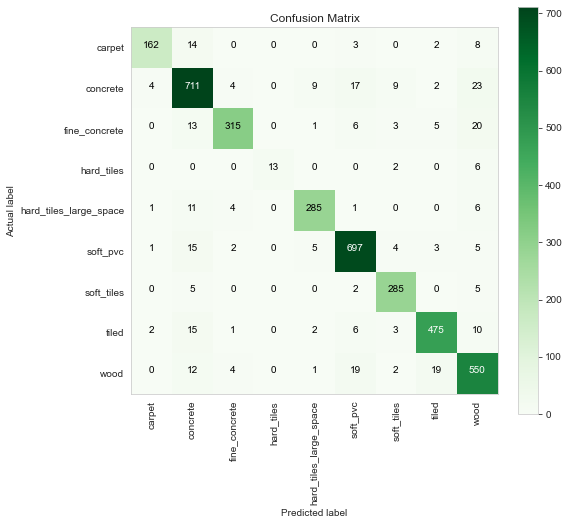

In [99]:
def plot_confusion_matrix(actual, predicted, classes, title='Confusion Matrix'):
    '''Plot confusion matrix for the model'''
    conf_matrix = confusion_matrix(actual, predicted)
    
    plt.figure(figsize=(8, 8))
    plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Greens)
    plt.title(title, size=12)
    plt.colorbar(fraction=0.05, pad=0.05)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    thresh = conf_matrix.max() / 2.
    for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
        horizontalalignment="center", color="white" if conf_matrix[i, j] > thresh else "black")

    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.grid(False)
    plt.tight_layout()
plot_confusion_matrix(target['surface'], oof_preds_rf, le.classes_, title='Confusion Matrix')

In [103]:
sub['surface'] = le.inverse_transform(sub_preds_rf.argmax(axis=1))
sub.to_csv('submission.csv', index=False)
sub.head(10)
# This part here is not necessary, it is just saving the results.

,series_id,surface
0,0,soft_pvc
1,1,wood
2,2,fine_concrete
3,3,wood
4,4,concrete
5,5,wood
6,6,soft_pvc
7,7,concrete
8,8,soft_tiles
9,9,wood


In [104]:
# Saving model as pickle file
with open('model.pkl', 'wb') as f:
    pickle.dump(model, f)

The best accuracy with RandomForestClassifier and 20 folds is 91%. Of course, there are chances to get a higher accuracy with more folds, or maybe with more n_estimators or another algorithm. So far, we are satisfied with the results of this algorithm.

So, if we want to make improvements, then we should try to tune the parameters, try another algorithm, try to control the orientation Z, which we saw that has to be under control more, maybe try different feature engineering, more features, and so on.<br/>
Knowing on what type of floor the robot is standing, can really help in the navigation process of the robot and having a better control over its moves.

So, what we did before is, we prepare the data for our model with converting quaternions to Euler angles, extracting features such as mean, standard deviation, etc., in order to get more information about the data and use it for our model. We used cross-validation and RandomForestClassifier and the best model so far, gave us pretty much good results.